## Style Transfer

Esta aula é baseada no tutorial disponibilizado no [site oficial do TensorFlow](https://www.tensorflow.org/tutorials/generative/style_transfer?hl=en).

### 1. Carregando dependências

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from datetime import datetime

## 2. Carregando e preparando o modelo

Vamos usar o modelo VGG19 sem o topo, que é a parte final da rede que faz a classificação das imagens.

In [ ]:
model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


## 3. Processamento das imagens

Vamos baixar uma image de conteúdo, sendo uma foto do Chaves, e uma imagem de estilo, sendo um auto-retrato do Van Gogh.

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project.jpg/493px-Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project.jpg -O vangogh.jpg
!wget https://img.huffingtonpost.com/asset/5d726f5f240000fb1777c53b.jpeg?ops=scalefit_630_noupscale -O chaves.jpeg

--2020-11-27 17:44:48--  https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project.jpg/493px-Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108318 (106K) [image/jpeg]
Saving to: ‘vangogh.jpg’

vangogh.jpg         100%[===================>] 105.78K  --.-KB/s    in 0.06s   

2020-11-27 17:44:49 (1.81 MB/s) - ‘vangogh.jpg’ saved [108318/108318]

--2020-11-27 17:44:49--  https://img.huffingtonpost.com/asset/5d726f5f240000fb1777c53b.jpeg?ops=scalefit_630_noupscale
Resolving img.huffingtonpost.com (img.huffingtonpost.com)... 192.229.210.207, 2606:2800:21f:2317:1818:390:aaa:218f
Connecting to img.huffingtonpost.com (img.huffingtonpost.com)|192.229.210.207|:443... connected.
HTTP request sent, a

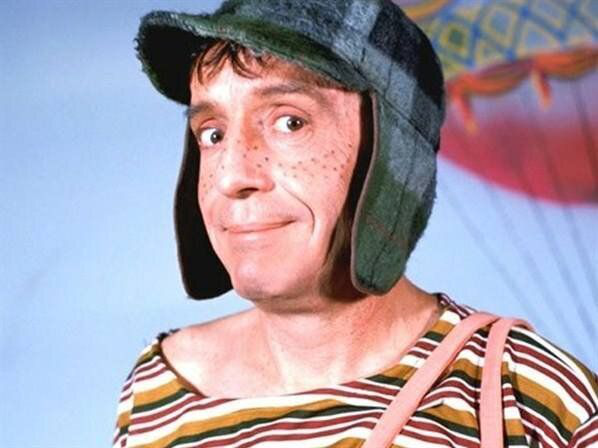

In [ ]:
cont_img = Image.open('chaves.jpeg')
cont_img

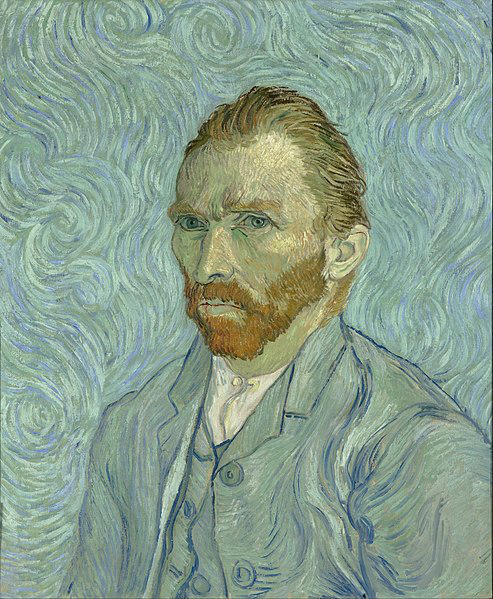

In [ ]:
style_img = Image.open('vangogh.jpg')
style_img

Para facilitar o processamento, vamos recarregar as imagens usando funções do TensorFlow.

In [ ]:
cont_img = tf.io.read_file('chaves.jpeg')
cont_img

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x01\xc0\x02V\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x00\x07\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\xff\xc4\x00L\x10\x00\x01\x03\x03\x02\x04\x04\x04\x03\x03\t\x07\x03\x03\x03\x05\x02\x00\x01\x03\x04\x05\x12\x06\x11\x13!"1\x072AB\x14QRb#ar\x153q$C\x81\x82\x91\x92\xa1\xb1\xb2\x08\x16%S\xa2\xc1\xc2\x17c\xd14\xd2\xf0&s\x835D\xe1\xe2\xf2\xff\xc4\x00\x1b\x01\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\xff\xc4\x00.\x11\x00\x02\x02\x01\x03\x04\x02\x02\x01\x05\x00\x02\x03\x00\x00\x00\x00\x01\x02

A imagem é carregada em formato de string. Vamos decodificá-la para inteiros com 3 canais de cores.

In [ ]:
cont_img = tf.image.decode_image(cont_img, channels = 3)
cont_img

<tf.Tensor: shape=(448, 598, 3), dtype=uint8, numpy=
array([[[121, 155, 203],
        [121, 155, 203],
        [121, 155, 203],
        ...,
        [ 97, 118, 139],
        [ 97, 118, 139],
        [ 97, 118, 139]],

       [[123, 157, 205],
        [123, 157, 205],
        [123, 157, 205],
        ...,
        [ 99, 120, 141],
        [ 99, 119, 143],
        [ 99, 120, 141]],

       [[123, 157, 205],
        [123, 157, 205],
        [123, 157, 205],
        ...,
        [ 98, 120, 143],
        [ 98, 120, 144],
        [ 98, 120, 143]],

       ...,

       [[184, 220, 254],
        [184, 220, 254],
        [184, 220, 254],
        ...,
        [255, 251, 252],
        [255, 250, 251],
        [255, 250, 250]],

       [[185, 221, 255],
        [184, 220, 254],
        [184, 220, 254],
        ...,
        [255, 249, 250],
        [255, 251, 252],
        [255, 252, 252]],

       [[185, 221, 255],
        [185, 221, 255],
        [184, 220, 254],
        ...,
        [255, 250, 25

E agora converter para tipo float. Verificando os 5 primeiros pixels nas direções horizontal e vertical, observamos que os valores agora foram também normalizados para o intervalo [0, 1].

In [ ]:
cont_img = tf.image.convert_image_dtype(cont_img, tf.float32)
cont_img[:5, :5, 0]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0.47450984, 0.47450984, 0.47450984, 0.47450984, 0.47450984],
       [0.48235297, 0.48235297, 0.48235297, 0.48235297, 0.48235297],
       [0.48235297, 0.48235297, 0.48235297, 0.48235297, 0.48235297],
       [0.48235297, 0.48235297, 0.48235297, 0.48235297, 0.48235297],
       [0.48627454, 0.48627454, 0.48627454, 0.48627454, 0.48627454]],
      dtype=float32)>

Agora vamos redimensionar a imagem para ter no máximo 512 pixels na maior dimensão. Primeiro definimos uma escala que vai resultar neste valor.

In [ ]:
shape = tf.cast(tf.shape(cont_img)[:-1], tf.float32) # estamos descartando a terceira dimensão (das cores), e convertendo para float, para poder dividir em seguida
long_dim = max(shape)
scale = 512/long_dim
scale

<tf.Tensor: shape=(), dtype=float32, numpy=0.8561873>

Agora multiplicamos o formato original por esta escala.

In [ ]:
new_shape = tf.cast(shape * scale, tf.int32)
cont_img = tf.image.resize(cont_img, new_shape)
cont_img.shape

TensorShape([383, 512, 3])

Veja que a maior dimensão agora é igual a 512. 

Precisamos ainda incluir uma dimensão no início da imagem, que corresponde à dimensão de batch.

In [ ]:
cont_img = cont_img[tf.newaxis, :]
cont_img.shape

TensorShape([1, 383, 512, 3])

Agora repetimos para a imagem de estilo.

In [ ]:
# Carregamento e conversão em float
style_img = tf.io.read_file('vangogh.jpg')
style_img = tf.image.decode_image(style_img, channels = 3)
style_img = tf.image.convert_image_dtype(style_img, tf.float32)

# Redimensionamento
shape = tf.cast(tf.shape(style_img)[:-1], tf.float32) # estamos descartando a terceira dimensão (das cores), e convertendo para float, para poder dividir em seguida
long_dim = max(shape)
scale = 512/long_dim
new_shape = tf.cast(shape * scale, tf.int32)
style_img = tf.image.resize(style_img, new_shape)

# Inserção da dimensão de batch
style_img = style_img[tf.newaxis, :]

Vai ser útil criar uma função para visualizar as imagens.

In [ ]:
def show_img(img):
    img = tf.squeeze(img, axis = 0) # para retirar a dimensão de batch
    return img

Visualizando as imagens processadas.

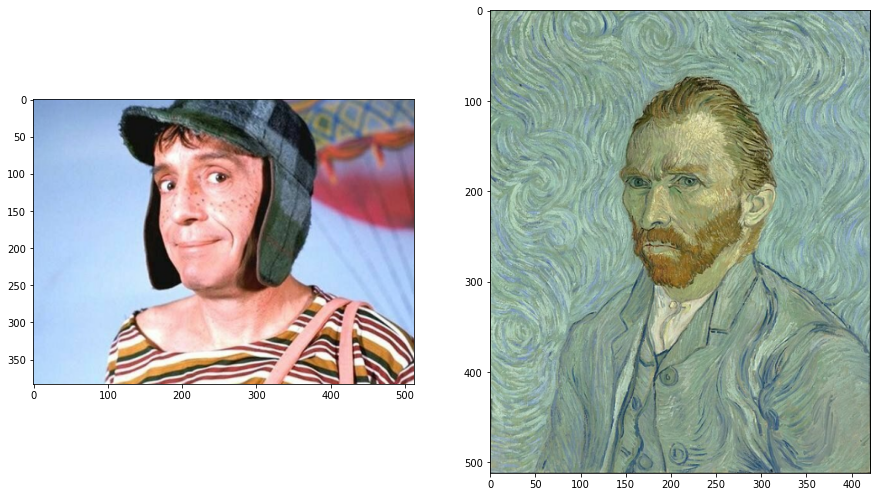

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 10))
axes[0].imshow(show_img(cont_img))
axes[1].imshow(show_img(style_img))

## 4. Preparação da estrutura da rede

Com base no nome das camadas visualizado acima, vamos definir quais são as camadas responsáveis por conteúdo e por estilo.

In [ ]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

Durante o treinamento, vamos precisar de variáveis com o número de camadas de conteúdo e de estilo, por isso vamos criar essas variáveis agora.

In [ ]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Vamos definir uma função que retorna um modelo que, por sua vez, retorna os valores após algumas camadas de interesse.

In [ ]:
def vgg_layers(layer_names):
    # O modelo-base será o VGG 19
    vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
    # Este modelo não será treinado...
    vgg.trainable = False
    
    # ... só retornará as saídas em camadas específicas
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    
    return model

Assim, nós podemos criar um extrator de estilos...

In [ ]:
style_extractor = vgg_layers(style_layers)

... e aplicá-lo para retirar o estilo da imagem do Van Gogh.

In [ ]:
style_outputs = style_extractor(style_img)
len(style_outputs)

5

Observe que temos uma lista com 5 elementos; cada elemento corresponde à saída de uma das 5 camadas de estilo.

In [ ]:
style_outputs[0].shape

TensorShape([1, 512, 421, 64])

Inspecionando a saída da primeira dessas camadas, observamos que é uma matriz de 4 dimensões, como esperávamos.

Para o processo de transferência de estilo, nós precisamos calcular uma medida que se chama *Gram matrix*, que é usada para determinar a perda entre a imagem gerada e a imagem de estilo. A Gram matrix é calculada da seguinte forma:

In [ ]:
def gram_matrix(tensor):
    # A função tf.linalg.einsum faz uma operação que se chama de contração do tensor, precisamos usar a forma específica abaixo
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    input_shape = tf.shape(tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/num_locations

Vamos definir uma classe para o modelo que vai processar as imagens e retornar todos os valores de interesse, ou seja, os tensores de conteúdo e as gram matrices dos tensores de estilo.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        # O modelo-base vai ser construído a partir da função que criamos anteriormente, capaz de produzir os tensores de conteúdo e de estilo
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        # Precisamos desnormalizar os inputs para o intervalo 0 a 255
        inputs = inputs * 255.
        # A função abaixo faz um preprocessamento padronizado para que imagens possam ser passadas para os modelos da família VGG
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        
        # Como o modelo contido em self.vgg retorna primeiro os tensores de estilo e depois os tensores de conteúdo, seguindo a ordem que definimos na sua construção acima, podemos separá-los com a implementação a seguir
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        
        # Gerando as gram matrices para os tensores de estilo
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        # Gerando dicionários contendo as saídas
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

Podemos verificar o resultado produzido pelo modelo criando uma instância e passando a imagem de conteúdo por ele.

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(cont_img)

In [ ]:
for key, value in results.items():
    print(key, ':', value.keys())

content : dict_keys(['block5_conv2'])
style : dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


Como esperado, nós vemos que a variável `results` contém duas chaves, `content` e `style`, e cada uma contém outros dicionários cujas chaves são os nomes das camadas correspondentes. Estes dicionários internos contém os tensores de conteúdo e as gram matrices de estilo.

Agora vamos definir os valores para os alvos de conteúdo e de estilo, que são as respectivas imagens passadas pelo extrator acima. Durante o treinamento da rede, a imagem gerada vai ser comparada com esses alvos com o objetivo de minimizar as perdas de conteúdo em comparação à imagem de conteúdo, e as perdas de estilo em comparação à imagem de estilo.

In [ ]:
style_targets = extractor(style_img)['style']
content_targets = extractor(cont_img)['content']

A imagem com conteúdo e estilo fusionado vai ser gerada a partir da imagem de conteúdo original. Ela vai ser atualizada durante o treinamento, por isso, vamos criar um tensor variável baseado na imagem original.

In [ ]:
new_img = tf.Variable(cont_img)

Definimos então um peso para o conteúdo e para o estilo, que será usado no cálculo de custo total durante o treinamento.

In [ ]:
content_weight = 1e4
style_weight = 1e-2

Por fim, definimos o otimizador do processo de treinamento.

In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.002)

## 5. Treinamento

ÉPOCA 0100/3000 | perda conteúdo: 242.268 | perda estilo: 1726719104.000 | perda total: 5876115.5
ÉPOCA 0200/3000 | perda conteúdo: 183.611 | perda estilo: 927232832.000 | perda total: 3690575.75
ÉPOCA 0300/3000 | perda conteúdo: 156.593 | perda estilo: 676744256.000 | perda total: 2919419.0
ÉPOCA 0400/3000 | perda conteúdo: 141.845 | perda estilo: 553341376.000 | perda total: 2525133.0
ÉPOCA 0500/3000 | perda conteúdo: 132.034 | perda estilo: 479940832.000 | perda total: 2280217.0


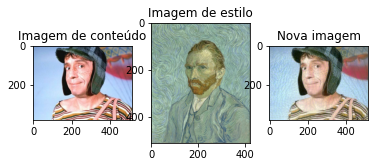

ÉPOCA 0600/3000 | perda conteúdo: 124.759 | perda estilo: 431524896.000 | perda total: 2110638.75
ÉPOCA 0700/3000 | perda conteúdo: 119.134 | perda estilo: 396009504.000 | perda total: 1983357.375
ÉPOCA 0800/3000 | perda conteúdo: 114.674 | perda estilo: 369456864.000 | perda total: 1885654.0
ÉPOCA 0900/3000 | perda conteúdo: 111.027 | perda estilo: 348792928.000 | perda total: 1807853.25
ÉPOCA 1000/3000 | perda conteúdo: 107.944 | perda estilo: 332394976.000 | perda total: 1744233.75


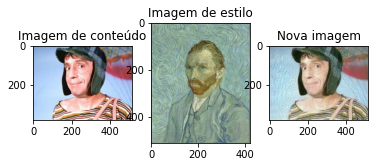

ÉPOCA 1100/3000 | perda conteúdo: 105.201 | perda estilo: 319275296.000 | perda total: 1690558.125
ÉPOCA 1200/3000 | perda conteúdo: 102.921 | perda estilo: 307664000.000 | perda total: 1644537.5
ÉPOCA 1300/3000 | perda conteúdo: 100.968 | perda estilo: 297676448.000 | perda total: 1605028.25
ÉPOCA 1400/3000 | perda conteúdo: 99.203 | perda estilo: 289303456.000 | perda total: 1570641.25
ÉPOCA 1500/3000 | perda conteúdo: 97.590 | perda estilo: 282217024.000 | perda total: 1540331.0


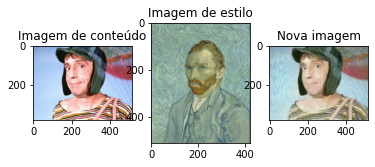

ÉPOCA 1600/3000 | perda conteúdo: 96.119 | perda estilo: 276172448.000 | perda total: 1513535.75
ÉPOCA 1700/3000 | perda conteúdo: 94.879 | perda estilo: 270548896.000 | perda total: 1489886.625
ÉPOCA 1800/3000 | perda conteúdo: 93.807 | perda estilo: 265194400.000 | perda total: 1468460.5
ÉPOCA 1900/3000 | perda conteúdo: 92.807 | perda estilo: 260645344.000 | perda total: 1449364.125
ÉPOCA 2000/3000 | perda conteúdo: 91.829 | perda estilo: 256849536.000 | perda total: 1431985.25


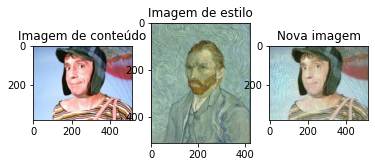

ÉPOCA 2100/3000 | perda conteúdo: 90.999 | perda estilo: 253111616.000 | perda total: 1416214.5
ÉPOCA 2200/3000 | perda conteúdo: 90.218 | perda estilo: 249668720.000 | perda total: 1401515.5
ÉPOCA 2300/3000 | perda conteúdo: 89.434 | perda estilo: 246656512.000 | perda total: 1387654.75
ÉPOCA 2400/3000 | perda conteúdo: 88.652 | perda estilo: 244090368.000 | perda total: 1374698.0
ÉPOCA 2500/3000 | perda conteúdo: 87.975 | perda estilo: 241279584.000 | perda total: 1362311.875


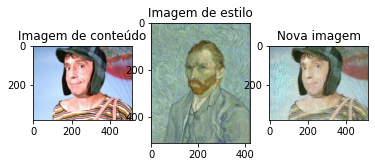

ÉPOCA 2600/3000 | perda conteúdo: 87.215 | perda estilo: 239185904.000 | perda total: 1350524.875
ÉPOCA 2700/3000 | perda conteúdo: 86.602 | perda estilo: 236741584.000 | perda total: 1339504.75
ÉPOCA 2800/3000 | perda conteúdo: 85.945 | perda estilo: 234735520.000 | perda total: 1328918.75
ÉPOCA 2900/3000 | perda conteúdo: 85.405 | perda estilo: 232529856.000 | perda total: 1319113.875
ÉPOCA 3000/3000 | perda conteúdo: 84.891 | perda estilo: 230624064.000 | perda total: 1310163.0


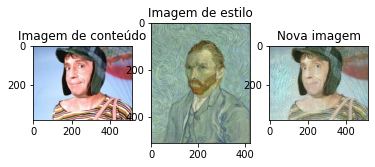

Processo demorou 0:06:10.999357


In [ ]:
epochs = 3000
print_loss_every = 100
print_images_every = 500

start = datetime.now()

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Gerando tensores relacionados ao conteúdo e ao estilo da imagem que está sendo atualizada
        outputs = extractor(new_img)
        
        # Separando as saídas de conteúdo e de estilo
        content_outputs = outputs['content']
        style_outputs = outputs['style']
        
        # Calculando as perdas de conteúdo e de estilo (MSE)
        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
        
        # Calculando a perda total como uma soma ponderada das perdas de conteúdo e de estilo
        total_loss = content_loss * content_weight / num_content_layers + style_loss * style_weight / num_style_layers
        
    # Determinando os gradientes em relação à nova imagem
    grad = tape.gradient(total_loss, new_img)
    
    # Aplicando os gradientes/atualizando os valores
    opt.apply_gradients([(grad, new_img)])
    
    # Aplicando uma função `clip` para evitar que os valores dos pixels extrapole o intervalo [0, 1] e atualizando a variável `new_img`
    new_img.assign(tf.clip_by_value(new_img, clip_value_min = 0.0, clip_value_max = 1.0))
    
    # Dados de treinamento da época
    if (epoch + 1) % print_loss_every == 0:
        print('ÉPOCA {:04d}/{} | perda conteúdo: {:3.3f} | perda estilo: {:3.3f} | perda total: {}'.format(epoch + 1, 
                                                                                                           epochs, 
                                                                                                           content_loss.numpy(),
                                                                                                           style_loss.numpy(),
                                                                                                           total_loss.numpy()))

    # Mostrando resultados intermediários
    if (epoch + 1) % print_images_every == 0:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(show_img(cont_img))
        ax1.set_title('Imagem de conteúdo')
        ax2.imshow(show_img(style_img))
        ax2.set_title('Imagem de estilo')
        ax3.imshow(show_img(new_img))
        ax3.set_title('Nova imagem')
        plt.show()

end = datetime.now()

print('Processo demorou {}'.format(end - start))

## 6. Resultados

Podemos agora ver o resultado final.

Text(0.5, 1.0, 'Imagem de estilo')

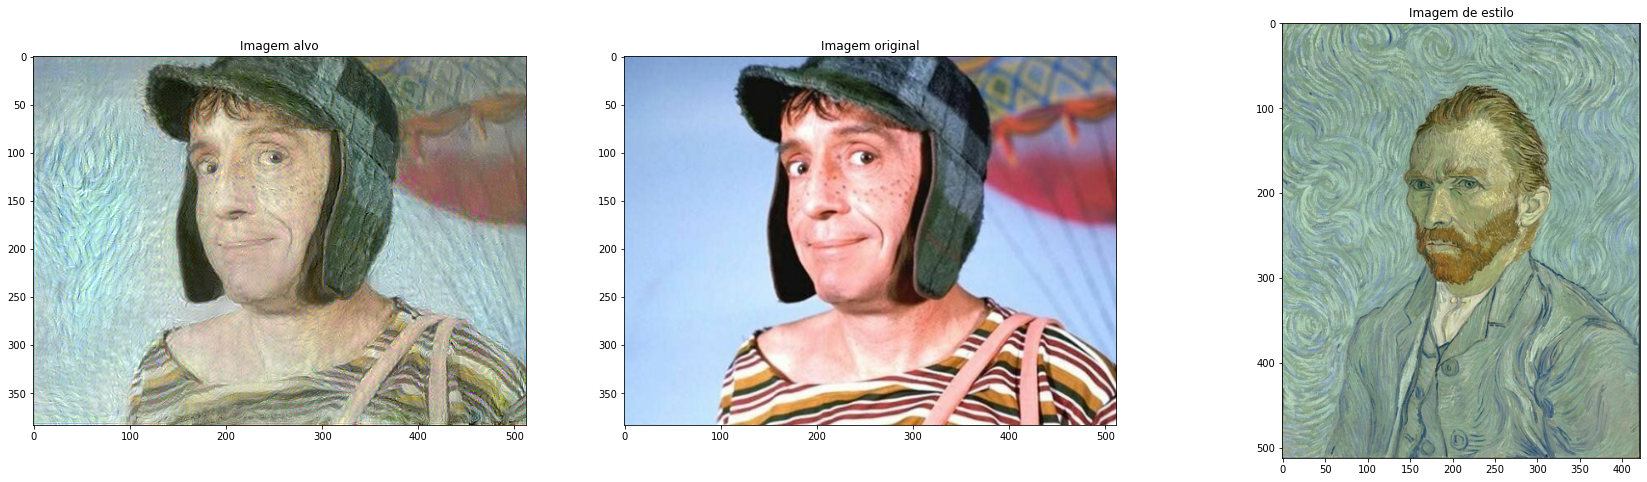

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
ax1.imshow(show_img(new_img))
ax1.set_title('Imagem alvo')
ax2.imshow(show_img(cont_img))
ax2.set_title('Imagem original')
ax3.imshow(show_img(style_img))
ax3.set_title('Imagem de estilo')